In [1]:
import os

from platform import python_version
import warnings
import time
import datetime as dt
from sklearn.metrics import classification_report, confusion_matrix
import multiprocessing as mp
import shutil

import matplotlib.pyplot as plt
import matplotlib.image as mpimg

import tensorflow as tf
from tensorflow.keras import backend as K
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications.densenet import DenseNet169, preprocess_input, decode_predictions
from tensorflow.keras.models import *
from tensorflow.keras.layers import *
from tensorflow.keras.optimizers import *
from tensorflow.keras.utils import *
from tensorflow.keras.callbacks import *
from tensorflow.keras.initializers import *
from tensorflow.keras import regularizers

import pandas as pd
import numpy as np
import seaborn as sns
from plotly.subplots import make_subplots
import plotly.graph_objects as go

from PIL import Image
import xml.etree.ElementTree as ET
import psutil
import random

warnings.filterwarnings("ignore")
%matplotlib inline

In [2]:
epochs = 100
batch_size = 48
testsplit = .5
targetx = 128
targety = 128
learning_rate = 0.0001
classes = 7
seed = random.randint(1, 1000)
target_names=['angry','disgust','fear','happy','neutral','sad','surprise']

data_dir = "/kaggle/input/fer2013/train/"
data_dir1 = "/kaggle/input/fer2013/test/"

In [3]:
train_datagen = ImageDataGenerator(
        rescale=1./255,
        shear_range=0.2,
        zoom_range=0.2,
        rotation_range=30,
        brightness_range=[0.9,1.1],
        horizontal_flip=True,
        fill_mode='nearest',
        preprocessing_function=preprocess_input
)

test_datagen = ImageDataGenerator(
        rescale=1./255,
        validation_split=testsplit,
        preprocessing_function=preprocess_input
)

train_generator = train_datagen.flow_from_directory(
        data_dir,
        target_size=(targetx, targety),
        batch_size=batch_size,
        class_mode='categorical',
        shuffle=True,
        seed=seed,
       
)
val_generator = test_datagen.flow_from_directory(
        data_dir1,
        target_size=(targetx, targety),
        batch_size=batch_size,
        class_mode='categorical',
        shuffle=False,
        seed=seed,
     subset="training"
        
)

test_generator = test_datagen.flow_from_directory(
        data_dir1,
        target_size=(targetx, targety),
        batch_size=batch_size,
        class_mode='categorical',
        shuffle=False,
    subset="validation",
        seed=seed
)

Found 28709 images belonging to 7 classes.
Found 3591 images belonging to 7 classes.
Found 3587 images belonging to 7 classes.


/kaggle/input/fer2013/train/neutral/Training_43961754.jpg


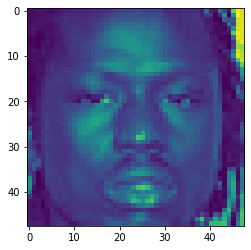

In [4]:
img = train_generator.filepaths[np.random.random_integers(low=0, high=train_generator.samples)]
print(img)
img = mpimg.imread(img)
plt.imshow(img)

In [5]:
checkpoint = ModelCheckpoint('DenseNet169.h5',
                             monitor='val_accuracy',
                             save_best_only=True,
                             verbose=1,
                             mode='auto',
                             save_weights_only=False,
                             period=1)

tensorboard = TensorBoard(log_dir="./logs-"+dt.datetime.now().strftime("%m%d%Y%H%M%S"),
                            histogram_freq=0,
                            batch_size=batch_size,
                            write_graph=False,
                            update_freq='epoch')

def epoch_end(epoch, logs):
    message = "End of epoch "+str(epoch)+". Learning rate: "+str(K.eval(model.optimizer.lr))
    os.system('echo '+message)

def epoch_begin(epoch, logs):
    print("Learning rate: ", K.eval(model.optimizer.lr))
    
def train_begin(logs):
    os.system("echo Beginning training")

earlystop = EarlyStopping(monitor='val_accuracy',
                          min_delta=.0001,
                          patience=20,
                          verbose=1,
                          mode='auto',
                          baseline=None,
                          restore_best_weights=True)

reducelr = ReduceLROnPlateau(monitor='val_accuracy',
                             factor=np.sqrt(.1),
                             patience=5,
                             verbose=1,
                             mode='auto',
                             min_delta=.0001,
                             cooldown=0,
                             min_lr=0.0000001)

lambdacb = LambdaCallback(on_epoch_begin=epoch_begin,
                          on_epoch_end=epoch_end,
                          on_batch_begin=None,
                          on_batch_end=None,
                          on_train_begin=train_begin,
                          on_train_end=None)

2023-01-24 00:31:29.301174: I tensorflow/core/profiler/lib/profiler_session.cc:131] Profiler session initializing.
2023-01-24 00:31:29.301215: I tensorflow/core/profiler/lib/profiler_session.cc:146] Profiler session started.
2023-01-24 00:31:29.375307: I tensorflow/core/profiler/internal/gpu/cupti_tracer.cc:1614] Profiler found 1 GPUs
2023-01-24 00:31:29.414368: I tensorflow/core/profiler/lib/profiler_session.cc:164] Profiler session tear down.
2023-01-24 00:31:29.414537: I tensorflow/core/profiler/internal/gpu/cupti_tracer.cc:1748] CUPTI activity buffer flushed


In [6]:
base_model = DenseNet169(include_top=False, weights='imagenet', input_shape=(targetx, targety, 3))

x = base_model.output
x = GlobalAveragePooling2D()(x)
x = BatchNormalization()(x)
x=Dropout(0.3)(x)
x = Dense(512, activation='relu',  kernel_initializer=glorot_uniform(seed),kernel_regularizer=regularizers.L2(0.001),activity_regularizer=regularizers.L2(1e-4), bias_initializer='zeros')(x)
x = BatchNormalization()(x)
x=Dropout(0.3)(x)
x = Dense(256, activation='relu',  kernel_initializer=glorot_uniform(seed),kernel_regularizer=regularizers.L2(0.001),activity_regularizer=regularizers.L2(1e-4), bias_initializer='zeros')(x)
x = BatchNormalization()(x)
x=Dropout(0.3)(x)
predictions = Dense(classes, activation='softmax', kernel_initializer='random_uniform', bias_initializer='zeros')(x)

model = Model(inputs=base_model.input, outputs=predictions)
optimizer = Adam(lr=learning_rate)
loss = "categorical_crossentropy"

for layer in model.layers:
    layer.trainable = True

model.compile(optimizer=optimizer,
              loss=loss,
              metrics=["accuracy"])

model.summary()
# for i, layer in enumerate(model.layers):
#     print(i, layer.name, layer.trainable)

2023-01-24 00:31:29.582489: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2023-01-24 00:31:29.674695: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2023-01-24 00:31:29.675572: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2023-01-24 00:31:29.676613: I tensorflow/core/platform/cpu_feature_guard.cc:142] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compil

51888128/51877672 [==============================] - 0s 0us/step
Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 128, 128, 3) 0                                            
__________________________________________________________________________________________________
zero_padding2d (ZeroPadding2D)  (None, 134, 134, 3)  0           input_1[0][0]                    
__________________________________________________________________________________________________
conv1/conv (Conv2D)             (None, 64, 64, 64)   9408        zero_padding2d[0][0]             
__________________________________________________________________________________________________
conv1/bn (BatchNormalization)   (None, 64, 64, 64)   256         conv1/conv[0][0]                 
_____________________________

In [7]:
# from tensorflow.keras.utils import plot_model
# plot_model(model, to_file='model.png', show_shapes=True, show_layer_names=True)
# from IPython.display import Image
# Image("model.png")

In [8]:
%%time

model_history = model.fit_generator(generator=train_generator, 
                                steps_per_epoch=len(train_generator), 
                                validation_data=val_generator, 
                                validation_steps=len(val_generator),
                                epochs=epochs,
                                callbacks=[reducelr, earlystop, lambdacb, tensorboard, checkpoint])

Beginning training
Epoch 1/100
Learning rate:  1e-04


2023-01-24 00:31:37.053521: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:185] None of the MLIR Optimization Passes are enabled (registered 2)
2023-01-24 00:31:53.905510: I tensorflow/stream_executor/cuda/cuda_dnn.cc:369] Loaded cuDNN version 8005


  1/599 [..............................] - ETA: 4:03:27 - loss: 3.2114 - accuracy: 0.1458

2023-01-24 00:32:01.519183: I tensorflow/core/profiler/lib/profiler_session.cc:131] Profiler session initializing.
2023-01-24 00:32:01.519241: I tensorflow/core/profiler/lib/profiler_session.cc:146] Profiler session started.


  2/599 [..............................] - ETA: 5:27 - loss: 3.2416 - accuracy: 0.1250   

2023-01-24 00:32:02.075624: I tensorflow/core/profiler/lib/profiler_session.cc:66] Profiler session collecting data.
2023-01-24 00:32:02.079761: I tensorflow/core/profiler/internal/gpu/cupti_tracer.cc:1748] CUPTI activity buffer flushed
2023-01-24 00:32:02.295895: I tensorflow/core/profiler/internal/gpu/cupti_collector.cc:673]  GpuTracer has collected 4033 callback api events and 4030 activity events. 
2023-01-24 00:32:02.450108: I tensorflow/core/profiler/lib/profiler_session.cc:164] Profiler session tear down.
2023-01-24 00:32:02.589910: I tensorflow/core/profiler/rpc/client/save_profile.cc:136] Creating directory: ./logs-01242023003129/train/plugins/profile/2023_01_24_00_32_02

2023-01-24 00:32:02.668555: I tensorflow/core/profiler/rpc/client/save_profile.cc:142] Dumped gzipped tool data for trace.json.gz to ./logs-01242023003129/train/plugins/profile/2023_01_24_00_32_02/d5541f6f84f6.trace.json.gz


  3/599 [..............................] - ETA: 7:33 - loss: 3.2625 - accuracy: 0.1389

2023-01-24 00:32:02.842071: I tensorflow/core/profiler/rpc/client/save_profile.cc:136] Creating directory: ./logs-01242023003129/train/plugins/profile/2023_01_24_00_32_02

2023-01-24 00:32:02.851249: I tensorflow/core/profiler/rpc/client/save_profile.cc:142] Dumped gzipped tool data for memory_profile.json.gz to ./logs-01242023003129/train/plugins/profile/2023_01_24_00_32_02/d5541f6f84f6.memory_profile.json.gz
2023-01-24 00:32:02.859779: I tensorflow/core/profiler/rpc/client/capture_profile.cc:251] Creating directory: ./logs-01242023003129/train/plugins/profile/2023_01_24_00_32_02
Dumped tool data for xplane.pb to ./logs-01242023003129/train/plugins/profile/2023_01_24_00_32_02/d5541f6f84f6.xplane.pb
Dumped tool data for overview_page.pb to ./logs-01242023003129/train/plugins/profile/2023_01_24_00_32_02/d5541f6f84f6.overview_page.pb
Dumped tool data for input_pipeline.pb to ./logs-01242023003129/train/plugins/profile/2023_01_24_00_32_02/d5541f6f84f6.input_pipeline.pb
Dumped tool data fo

599/599 [==============================] - 311s 480ms/step - loss: 2.4471 - accuracy: 0.4361 - val_loss: 2.5079 - val_accuracy: 0.3514
End of epoch 0. Learning rate: 1e-04

Epoch 00001: val_accuracy improved from -inf to 0.35143, saving model to DenseNet169.h5
Epoch 2/100
Learning rate:  1e-04
599/599 [==============================] - 188s 314ms/step - loss: 1.9470 - accuracy: 0.5674 - val_loss: 1.7812 - val_accuracy: 0.6021
End of epoch 1. Learning rate: 1e-04

Epoch 00002: val_accuracy improved from 0.35143 to 0.60206, saving model to DenseNet169.h5
Epoch 3/100
Learning rate:  1e-04
599/599 [==============================] - 186s 311ms/step - loss: 1.7677 - accuracy: 0.6091 - val_loss: 1.6662 - val_accuracy: 0.6271
End of epoch 2. Learning rate: 1e-04

Epoch 00003: val_accuracy improved from 0.60206 to 0.62712, saving model to DenseNet169.h5
Epoch 4/100
Learning rate:  1e-04
599/599 [==============================] - 186s 310ms/step - loss: 1.6409 - accuracy: 0.6333 - val_loss: 1.64

In [9]:
history = pd.DataFrame(model_history.history)
history.to_csv('DenseNet169.csv', index=False)
history

,loss,accuracy,val_loss,val_accuracy,lr
0,2.447074,0.436100,2.507912,0.351434,1.000000e-04
1,1.946980,0.567418,1.781248,0.602061,1.000000e-04
2,1.767738,0.609112,1.666240,0.627123,1.000000e-04
3,1.640930,0.633321,1.649816,0.636870,1.000000e-04
4,1.548619,0.647184,1.513624,0.653021,1.000000e-04
5,1.455071,0.669755,1.486294,0.642161,1.000000e-04
6,1.375257,0.678463,1.441745,0.653857,1.000000e-04
7,1.295404,0.694033,1.356482,0.665831,1.000000e-04
8,1.229868,0.703542,1.392494,0.651351,1.000000e-04
9,1.167692,0.716012,1.283636,0.674742,1.000000e-04


<h2>Plotting<h2>

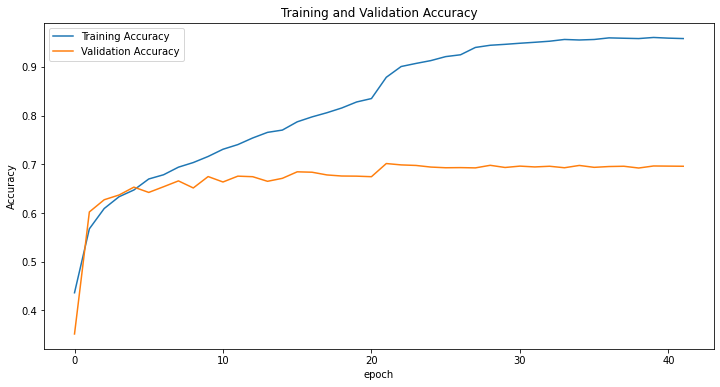

In [10]:
f, ax=plt.subplots(figsize=(12,6))
plt.plot(model_history.history['accuracy'], label='Training Accuracy')
plt.plot(model_history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Training and Validation Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('epoch')
plt.legend()
plt.show()

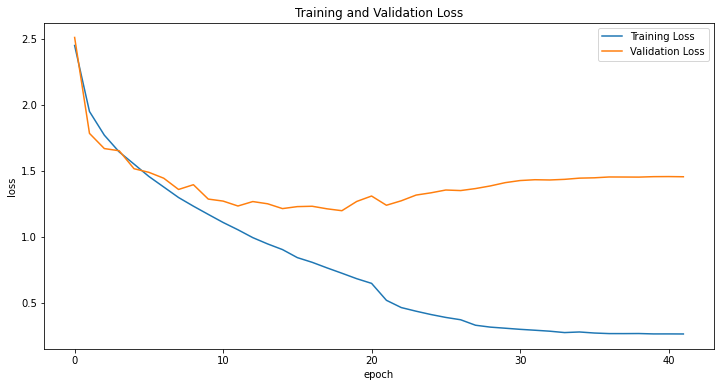

In [11]:
f, ax=plt.subplots(figsize=(12,6))
plt.plot(model_history.history['loss'], label='Training Loss')
plt.plot(model_history.history['val_loss'], label='Validation Loss')
plt.title('Training and Validation Loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend()
plt.show()

<h2>Model Evaluation<h2>

In [12]:
predictions = model.predict_generator(test_generator, steps=len(test_generator))
y = np.argmax(predictions, axis=1)

print('Classification Report')
cr = classification_report(y_true=test_generator.classes, y_pred=y, target_names=test_generator.class_indices)
print(cr)

Classification Report
              precision    recall  f1-score   support

       angry       0.63      0.66      0.64       479
     disgust       0.83      0.64      0.72        55
        fear       0.62      0.54      0.58       512
       happy       0.90      0.90      0.90       887
     neutral       0.61      0.75      0.68       616
         sad       0.60      0.53      0.57       623
    surprise       0.84      0.80      0.82       415

    accuracy                           0.71      3587
   macro avg       0.72      0.69      0.70      3587
weighted avg       0.71      0.71      0.71      3587



In [13]:
#confusion matrix
Y_pred = model.predict_generator(test_generator)
y_pred = np.argmax(Y_pred, axis=1)
y_true=test_generator.classes


from sklearn.metrics import confusion_matrix
cm=confusion_matrix(y_true,y_pred)
cm

array([[314,   2,  43,  16,  46,  51,   7],
       [ 14,  35,   1,   1,   3,   0,   1],
       [ 61,   2, 276,  12,  58,  71,  32],
       [ 14,   1,  10, 802,  34,   9,  17],
       [ 23,   2,  24,  22, 465,  77,   3],
       [ 60,   0,  61,  23, 142, 333,   4],
       [ 11,   0,  31,  16,  12,  11, 334]])

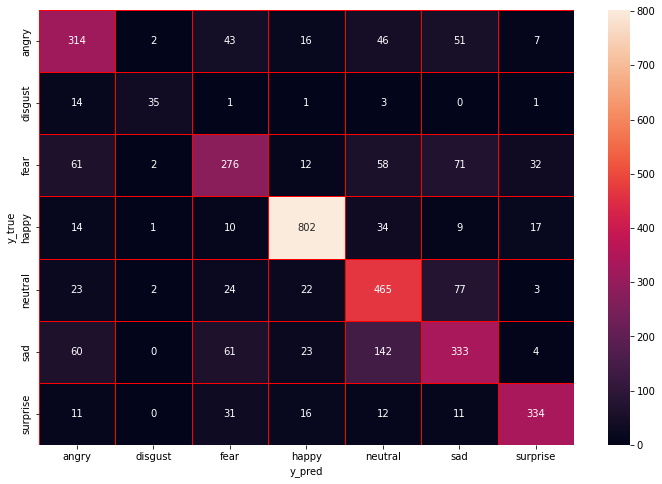

In [14]:
f, ax=plt.subplots(figsize=(12,8))
sns.heatmap(cm,annot=True,linewidths=0.5,linecolor="red",fmt=".0f",ax=ax,xticklabels=target_names, yticklabels=target_names,)
plt.xlabel("y_pred")
plt.ylabel("y_true")
plt.show()

In [15]:
model.evaluate(test_generator , verbose = 1)

75/75 [==============================] - 6s 82ms/step - loss: 1.1829 - accuracy: 0.7134


[1.1829458475112915, 0.7134095430374146]

In [16]:
# #Test the model
# model = load_model('./DenseNet201.h5')

# test_image='../input/fer2013/test/happy/PrivateTest_11155116.jpg'
# image_result=Image.open(test_image)

# from tensorflow.keras.preprocessing import image
# test_image=image.load_img(test_image,target_size=(targetx, targety))
# test_image=image.img_to_array(test_image)
# test_image=test_image/255
# test_image=np.expand_dims(test_image,axis=0)

# result=model.predict(test_image)
# print(np.argmax(result))
# Categories =target_names
# image_result=plt.imshow(image_result)
# plt.title(Categories[np.argmax(result)])
# plt.show()